# 1. Prep Work

In [419]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Callable 

#### a)$$I = \int_a^b20-x^2dx$$

$$I = 20b - \frac{b^3}{3} - (20a - \frac{a^3}{3}) + c$$

In [2]:
#b)
def f(x: float) -> float:
    y = 20 - x**2
    return y


In [3]:
#c)
def I(a: float, b: float) -> float: 
    return 20*b - (b**3)/3 - 20*a + (a**3)/3

# 2. Basic Monte Carlo

### a) $$\mathbb{E}^{p}[I^{Basic}_n] = I$$

In [361]:
#b) 

def mc_basic(f: Callable[[float], float], a: float, b: float, n: int) -> tuple[float, float]:
    px = 1 / (b - a)
    ys = np.array(list(map(f,np.random.uniform(a,b,n))))
    print(ys)
    I = np.mean(ys/px)
    var_I = np.var(ys/px)/n
    
    return I,var_I

### c) $$Var({I^{Basic}_n}) = \frac{1}{n}\cdot[E(g(x)^2) - E(g(x))^2]$$

$$= \frac{1}{n}\left[\int_a^b\frac{f(x)^2}{p(x)^2}\cdot p(x)dx - \left(\int_a^b\frac{f(x)}{p(x)}\cdot p(x)dx\right)^2\right]$$

$$ =\frac{1}{n}\left[\int_a^b\frac{f(x)^2}{p(x)}dx - \left(\int_a^bf(x)dx\right)^2\right]$$

$$= \frac{1}{n}\left[(b-a) \int_{a}^{b} (20 - x^2)^2 \, dx - \left(\int_{a}^{b} (20 - x^2) \, dx\right)^2\right]$$


$$= \frac{1}{n}\left[\left((b-a)\left(400x - \frac{40x^3}{3} + \frac{x^5}{5}\right) - \left(20x - \frac{x^3}{3}\right)^2\right)^{\Big|_{a}^{b}}\right]$$



$$= \frac{1}{n}\left[(b-a)\left(400(b-a) - \frac{40(b^3-a^3)}{3} + \frac{b^5-a^5}{5}\right) - \left(20(b-a) - \frac{)b^3-a^3)}{3}\right)^2\right]$$



In [39]:
#d)

def mc_basic_variance_true(a: float, b: float, n: int) -> float:
    return ((b-a)*(400*(b-a)-40*(b**3-a**3)/3+(b**5-a**5)/5)-(20*(b-a)-(b**3-a**3)/3)**2)/n

In [232]:
#e)

metric = ["integral_true","integral_estiamte","difference", "sigma^2_estiamte/n","sigma^2_estimate","sigma^2_true/n","sigma^2_true"]
value = [I(-1,3),mc_basic(f, -1, 3, 100000)[0],I(-1,3)-mc_basic(f, -1, 3, 100000)[0],mc_basic(f, -1, 3, 100000)[1],100000*mc_basic(f, -1, 3, 100000)[1],mc_basic_variance_true(-1,3,100000),mc_basic_variance_true(-1,3,100000)*100000]
d = pd.DataFrame({"Metric":metric,"Value":value})
d

,Metric,Value
0,integral_true,70.666667
1,integral_estiamte,70.700756
2,difference,0.031434
3,sigma^2_estiamte/n,0.001078
4,sigma^2_estimate,107.920705
5,sigma^2_true/n,0.001081
6,sigma^2_true,108.088889


# 3. Antithetic uniform samples

## a) $$\mathbb{E}^{p}[I^{Antithetic}_n] = I$$

In [199]:
#b)

def mc_antithetic(f: Callable[[float], float], a: float, b: float, n: int) -> tuple[float, float]:
    px = 1 / (b - a)
    u = np.random.uniform(0,1,int(n/2))
    xs = a + (b-a) * u    #transformation 
    xs2 = a + (b-a) * (1-u) 
    ys = np.array(list(map(f,xs)))
    ys2 = np.array(list(map(f,xs2)))
    I = (np.sum(ys/px) + np.sum(ys2/px))/n
    
    var_I = ((np.var(ys/px)+np.var(ys2/px))/2 + np.cov(ys/px,ys2/px)[1,0])/n #introduce negative covariance
    
    return I,var_I

In [201]:
#c) 

metric = ["integral_true","integral_estiamte","difference", "sigma^2_estiamte/n","sigma^2_estimate"]
value = [I(-1,3),mc_antithetic(f, -1, 3, 100000)[0],I(-1,3)-mc_antithetic(f, -1, 3, 100000)[0],mc_antithetic(f, -1, 3, 100000)[1],100000*mc_antithetic(f, -1, 3, 100000)[1]]
d = pd.DataFrame({"Metric":metric,"Value":value})
d

,Metric,Value
0,integral_true,70.666667
1,integral_estiamte,70.647256
2,difference,-0.013044
3,sigma^2_estiamte/n,0.000453
4,sigma^2_estimate,45.410363


# 4) Control Variate

## a) $$\mathbb{E}^{p}[I^{ControlVariate}_n] = I$$

In [206]:
#b)

def h1(x: float) -> float:
    return 20*np.cos(x/3)

def h2(x: float) -> float: 
    return 20*np.sin(x/3)

def H1(a: float, b: float) -> float:
    return 60 * (np.sin(b/3) - np.sin(a/3))

def H2(a: float, b: float) -> float:
    return -60 * (np.cos(b/3)-np.cos(a/3))


In [230]:
#c) 

def mc_control_variate(f: Callable[[float], float], a: float, b: float, n: int, h: Callable[[float], float], H: Callable[[float, float], float]) -> tuple[float, float]:
    px = 1 / (b - a)
    u = np.random.uniform(a,b,n)
    ys = np.array(list(map(f,u)))
    hs = np.array(list(map(h,u)))
    I = np.mean((ys-hs)/px) + H(a,b)
    var_I = ((np.var(ys/px)+np.var(hs/px)) - 2 * np.cov(ys/px,hs/px)[1,0])/n
    
    return I,var_I


In [231]:
#d) 
metric = ["integral_true","integral_estiamte","difference", "sigma^2_estiamte/n","sigma^2_estimate"]
integral1 = [I(-1,3),mc_control_variate(f, -1, 3, 100000, h1, H1)[0],I(-1,3)-mc_control_variate(f, -1, 3, 100000, h1, H1)[0],mc_control_variate(f, -1, 3, 100000, h1, H1)[1],100000*mc_control_variate(f, -1, 3, 100000, h1, H1)[1]]
integral2 = [I(-1,3),mc_control_variate(f, -1, 3, 100000, h2, H2)[0],I(-1,3)-mc_control_variate(f, -1, 3, 100000, h2, H2)[0],mc_control_variate(f, -1, 3, 100000, h2, H2)[1],100000*mc_control_variate(f, -1, 3, 100000, h2, H2)[1]]

d = pd.DataFrame({"Metric":metric,"Integral h1":integral1, "Integral h2":integral2})
d

,Metric,Integral h1,Integral h2
0,integral_true,70.666667,70.666667
1,integral_estiamte,70.665535,70.630899
2,difference,-0.000211,-0.104330
3,sigma^2_estiamte/n,0.000002,0.013880
4,sigma^2_estimate,0.199540,1386.526957


e) from the table we can see that integral h1 is beter as it gives us smaller variance of estimator 

f) Compared to the basic estimate, the integral estiamte is about the same while the variance is decreased, which is what I expected

# 5) Importance Sampling

## a) $$\mathbb{E}^{p}[I^{Importance}_n] = I$$

In [411]:
#b) 
from scipy.stats import norm

def mc_importance(f: Callable[[float], float], a: float, b: float, n: int, sigma: float) -> tuple[float, float, float]:
    
    cdf_low = norm.cdf(a,0,sigma) #scaling
    cdf_up = norm.cdf(b,0,sigma)    
    scaling = 1/ (cdf_up - cdf_low) 
    
    xs = np.random.normal(0,sigma,n)
    n_selected = np.array([x for x in xs if a <= x <= b]) #choose n between -1 & 3
    
    pdf = norm.pdf(n_selected, 0, sigma) * scaling
    
    ys = np.array(list(map(f,n_selected)))
    
    I = np.mean(ys/pdf)
    var_I = np.var(ys/pdf)/len(n_selected)
    
    return I,var_I, len(n_selected)

In [414]:
#c)
sigma_values = list(range(1, 11))  # [0, 1, 2, ..., 10]

metric = ["integral_true", "integral_estimate", "difference", "sigma^2_estimate/n", "sigma^2_estimate","n_selected"]

metric_data = {m: [] for m in metric}

for sigma in sigma_values:
    mc_result = mc_importance(f, -1, 3, 100000, sigma)
    metric_data["integral_true"].append(I(-1, 3))
    metric_data["integral_estimate"].append(mc_result[0])
    metric_data["difference"].append(I(-1, 3) - mc_result[0])
    metric_data["sigma^2_estimate/n"].append(mc_result[1])
    metric_data["sigma^2_estimate"].append(mc_result[2] * mc_result[1])
    metric_data["n_selected"].append(mc_result[2])

df = pd.DataFrame(metric_data)

df


,integral_true,integral_estimate,difference,sigma^2_estimate/n,sigma^2_estimate,n_selected
0,70.666667,70.331331,0.335336,0.111053,9330.117828,84015
1,70.666667,70.642921,0.023746,0.001822,113.974258,62557
2,70.666667,70.667419,-0.000752,0.000034,1.605476,47113
3,70.666667,70.696236,-0.029569,0.000711,26.347145,37081
4,70.666667,70.686421,-0.019754,0.001611,49.050628,30441
5,70.666667,70.665697,0.000970,0.002537,65.236471,25714
6,70.666667,70.554489,0.112177,0.003393,75.569056,22274
7,70.666667,70.648094,0.018573,0.004219,82.956256,19662
8,70.666667,70.706941,-0.040274,0.005059,87.655350,17326
9,70.666667,70.667697,-0.001031,0.005856,92.399231,15778


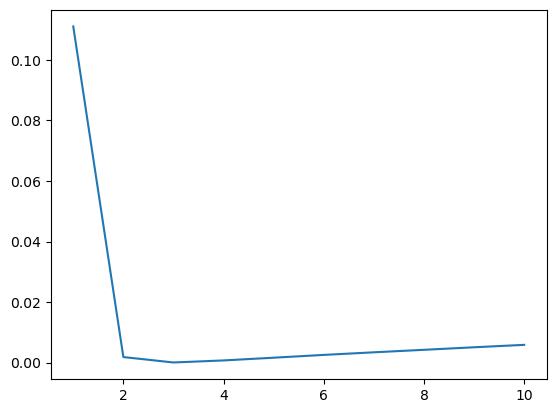

In [420]:
#d) Which of the 10 importance sampling estimators is best? Why? Use a graph if you need to support your answer.

# Variance of the estimator is the lowest for sigma = 3, so the normal with mean 0 and sigma 3 is the best?
# The reason is the interval that we picked is [-1,3]. Thus, most of the value that we are choosing is within
# the within one standard deviation from mean (also the best compared to other sigmas)
 
plt.plot(sigma_values,metric_data["sigma^2_estimate/n"])

In [ ]:
#e) How do your results compare to the basic estimate? Is this what you expect?

#It's better as is what i expected 

In [ ]:
#f) Comment on what happens to “n_used” as σ increases. Why does this happen?

# n_used decreases as σ increases as less values are contained in the [-1,3] 
# as the data are more deviated away from the mean 0
